In [1]:
%matplotlib inline

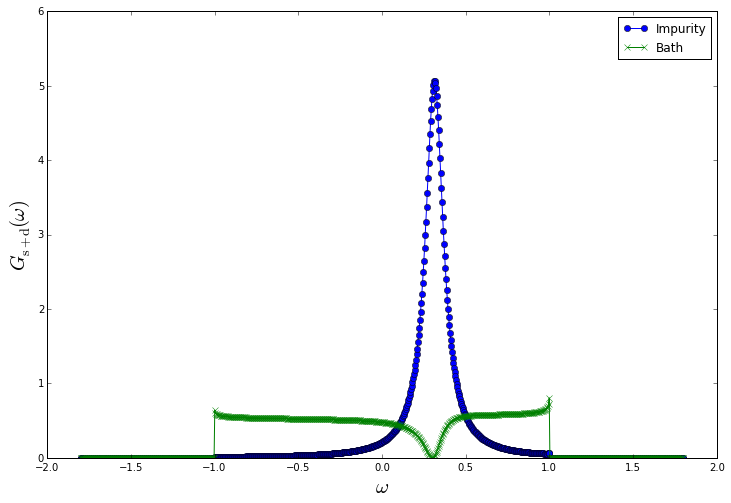

In [3]:
from pytriqs.gf.local import GfReFreq, Omega, Wilson, inverse
import numpy

eps_d,t  = 0.3, 0.2

# Create the real-frequency Green's function and initialize it
g = GfReFreq(indices = ['s','d'], window = (-2, 2), n_points = 1000, name = "$G_\mathrm{s+d}$")
g['d','d'] = Omega - eps_d
g['d','s'] = t
g['s','d'] = t
g['s','s'] = inverse( Wilson(1.0) )
g.invert()

# Plot it with matplotlib. 'S' means: spectral function ( -1/pi Imag (g) )
from pytriqs.plot.mpl_interface import oplot
oplot( g['d','d'], '-o', RI = 'S', x_window  = (-1.8,1.8), name = "Impurity" )
oplot( g['s','s'], '-x', RI = 'S', x_window  = (-1.8,1.8), name = "Bath" )

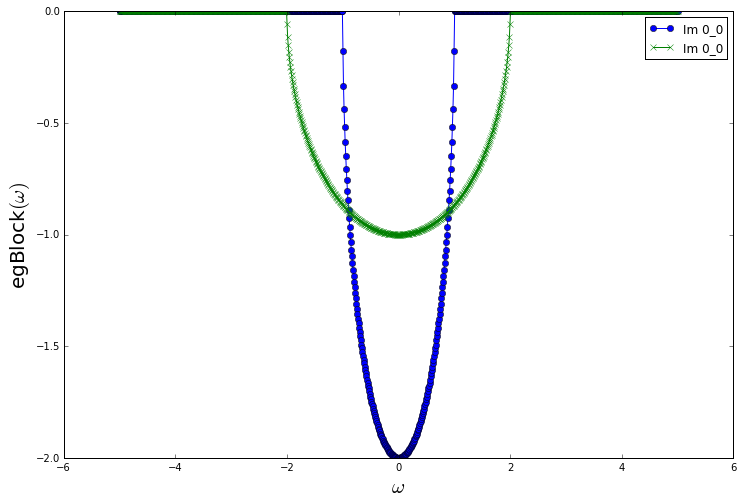

In [5]:
import numpy as np
from pytriqs.gf.local import GfReFreq, SemiCircular

g = GfReFreq(indices = ['eg1', 'eg2'], window = (-5, 5), n_points = 1000, name = "egBlock")

g['eg1','eg1'] = SemiCircular(half_bandwidth = 1)
g['eg2','eg2'] = SemiCircular(half_bandwidth = 2)

from pytriqs.plot.mpl_interface import oplot
oplot(g['eg1','eg1'], '-o', RI = 'I')  # S : spectral function
oplot(g['eg2','eg2'], '-x', RI = 'I')

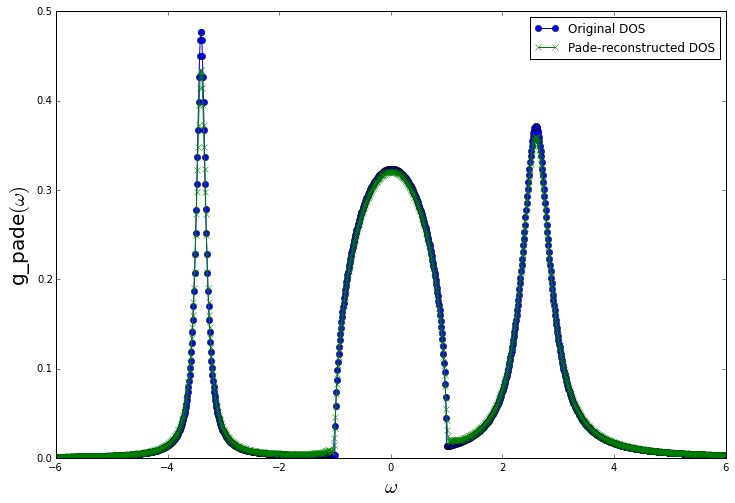

In [6]:
import numpy
from math import pi
from cmath import sqrt, log
from pytriqs.gf.local import *
from pytriqs.gf.local.descriptors import Function

beta = 100  # Inverse temperature
L = 101     # Number of Matsubara frequencies used in the Pade approximation
eta = 0.01  # Imaginary frequency shift

## Test Green's functions ##

# Two Lorentzians
def GLorentz(z):
    return 0.7/(z-2.6+0.3*1j) + 0.3/(z+3.4+0.1*1j)

# Semicircle
def GSC(z):
    return 2.0*(z + sqrt(1-z**2)*(log(1-z) - log(-1+z))/pi)

# A superposition of GLorentz(z) and GSC(z) with equal weights
def G(z):
    return 0.5*GLorentz(z) + 0.5*GSC(z)

# Matsubara GF
gm = GfImFreq(indices = [0], beta = beta, name = "gm")
gm << Function(G)
gm.tail.zero()
gm.tail[1] = numpy.array([[1.0]])

# Real frequency BlockGf(reference)
gr = GfReFreq(indices = [0], window = (-5.995, 5.995), n_points = 1200, name = "gr")
gr << Function(G)
gr.tail.zero()
gr.tail[1] = numpy.array([[1.0]])

# Analytic continuation of gm
g_pade = GfReFreq(indices = [0], window = (-5.995, 5.995), n_points = 1200, name = "g_pade")
g_pade.set_from_pade(gm, n_points = L, freq_offset = eta)

# Comparison plot
from pytriqs.plot.mpl_interface import oplot
oplot(gr[0,0], '-o', RI = 'S', name = "Original DOS")
oplot(g_pade[0,0], '-x', RI = 'S', name = "Pade-reconstructed DOS")

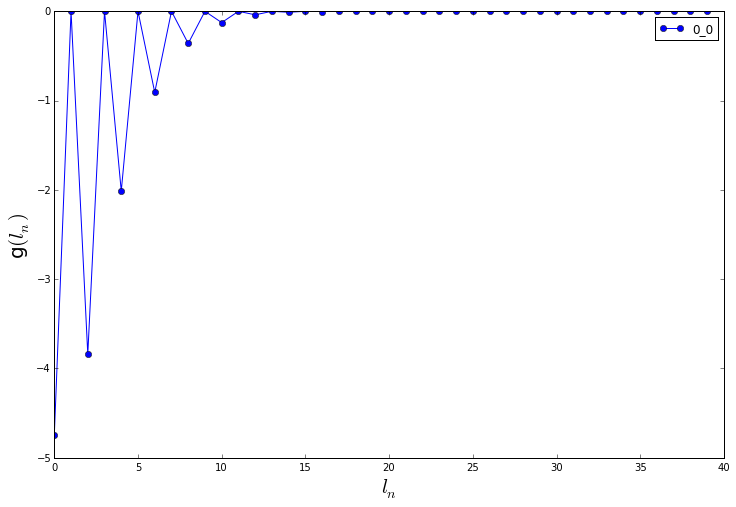

In [11]:
from pytriqs.gf.local import *
from pytriqs.plot.mpl_interface import oplot,plt

# A Green's function on the Matsubara axis set to a semicircular
gw = GfImFreq(indices = [1], beta = 50)
gw << SemiCircular(half_bandwidth = 1)

# Create a Legendre Green's function with 40 coefficients
# and initialize it from gw
gl = GfLegendre(indices = [1], beta = 50, n_points = 40)
gl << MatsubaraToLegendre(gw)

# Plot the Legendre Green's function
oplot(gl, '-o')

In [12]:
from pytriqs.gf.local import *
from pytriqs.gf.local import *
from pytriqs.operators import *
from pytriqs.archive import *
import pytriqs.utility.mpi as mpi

# Set up a few parameters
U = 2.5
half_bandwidth = 1.0
chemical_potential = U/2.0
beta = 100
n_loops = 5

# Construct the CTQMC solver
from pytriqs.applications.impurity_solvers.cthyb import Solver
S = Solver(beta = beta, gf_struct = { 'up':[0], 'down':[0] })

# Set the solver parameters
params = {}
params['n_cycles'] = 1000000                # Number of QMC cycles
params['length_cycle'] = 200                # Length of one cycle
params['n_warmup_cycles'] = 10000           # Warmup cycles

# Initalize the Green's function to a semi-circular density of states
g0_iw = GfImFreq(indices = [0], beta = 100)
g0_iw << SemiCircular(half_bandwidth)
for name, g0block in S.G_tau:
    g0block << InverseFourier(g0_iw)

# Now do the DMFT loop
for IterationNumber in range(n_loops):

    # Compute S.G0_iw with the self-consistency condition while imposing paramagnetism
    g = 0.5 * Fourier( S.G_tau['up'] + S.G_tau['down'] )
    for name, g0 in S.G0_iw:
        g0 << inverse( iOmega_n + chemical_potential - (half_bandwidth/2.0)**2  * g )

    # Run the solver
    S.solve(h_loc = U * n('up',0) * n('down',0), **params)

    # Some intermediate saves
    if mpi.is_master_node():
      R = HDFArchive("single_site_bethe.h5")
      R["G_tau-%s"%IterationNumber] = S.G_tau
      del R

!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------------------------------------------------!
!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------------------------------------------------!
!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------

Starting on 1 Nodes at : 2015-03-29 23:47:01.940212


HDFArchive (partial view) with the following content:
  G_tau-0 : subgroup
  G_tau-1 : subgroup
  G_tau-2 : subgroup
  G_tau-3 : subgroup
  G_tau-4 : subgroup
G_tau-4


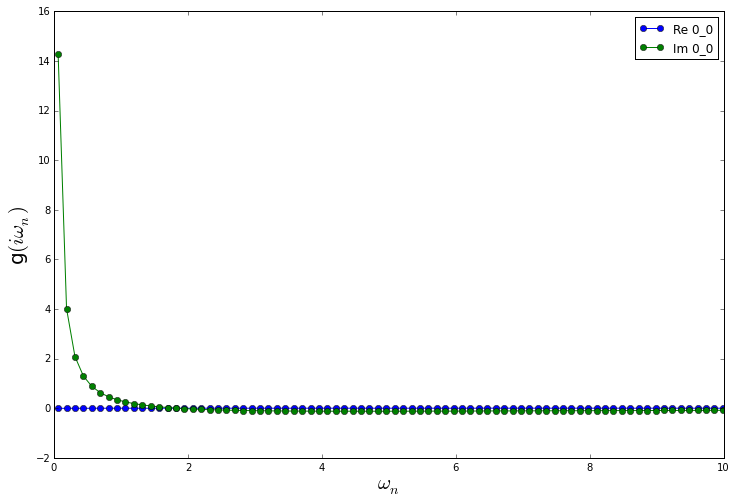

In [12]:
from pytriqs.gf.local import *
from pytriqs.archive import *
from pytriqs.plot.mpl_interface import oplot

A = HDFArchive("single_site_bethe.h5")
G_iw = GfImFreq(indices = [0], beta = 50.0)
print A
print A['G_tau-4']
G_iw << Fourier(A['G_tau-0']['up'])
oplot(G_iw, '-o', x_window = (0,10))

In [13]:
#http://ipht.cea.fr/triqs/1.2/tour/ctqmc.html
from pytriqs.gf.local import *
from pytriqs.operators import *
from pytriqs.applications.impurity_solvers.cthyb import Solver

# Parameters
D, t, U = 1.0, 0.2, 4.0
e_f, beta = -U/2.0, 50.0

# Construct the impurity solver with the inverse temperature
# and the structure of the Green's functions
S = Solver(beta = beta, gf_struct = {'up':[0], 'down':[0]})

# Initialize the non-interacting Green's function S.G0_iw
for spin, g0 in S.G0_iw:
    g0 << inverse( iOmega_n - e_f - t**2 * Wilson(D) )

# Set the solver parameters.
params = {}
params['n_cycles'] = 1000000                # Number of QMC cycles
params['length_cycle'] = 200                # Length of one cycle
params['n_warmup_cycles'] = 10000           # Warmup cycles
params['measure_g_l'] = True                # Measure G in legendre

# Run the solver. The result will be stored in S.G_tau.
S.solve(h_loc = U * n('up',0) * n('down',0), **params)

# Save the results in an hdf5 file (only on the master node).
from pytriqs.archive import HDFArchive
import pytriqs.utility.mpi as mpi

if mpi.is_master_node():
  Results = HDFArchive("solution.h5",'w')
  Results["G_tau"] = S.G_tau
  Results["G_l"] = S.G_l

!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------------------------------------------------!


Starting on 1 Nodes at : 2015-03-30 14:22:13.075970


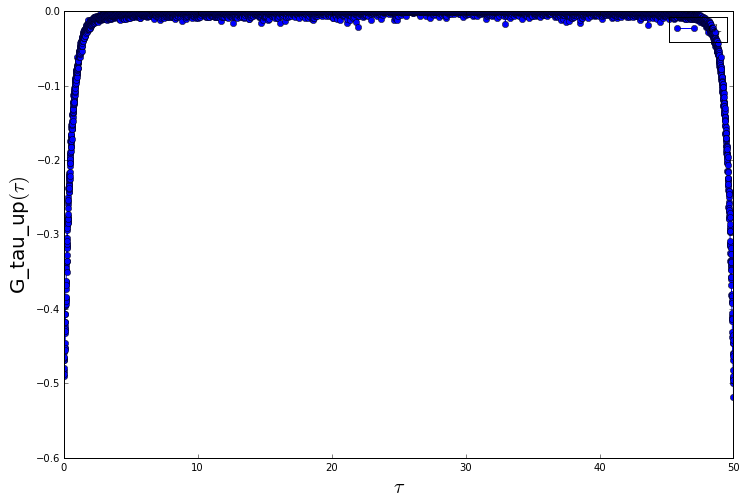

In [21]:
from pytriqs.gf.local import *
from pytriqs.archive import *
from pytriqs.plot.mpl_interface import oplot

A = HDFArchive("solution.h5")
G_iw = GfImFreq(indices = [0], beta = 50.0)
G_iw << Fourier(A['G_tau']['up'])
#oplot(G_iw, '-o', x_window = (0,10), name = "G_up")
oplot(A['G_tau']['up'], '-o', name = r"$G_\tau$")

In [2]:
from pytriqs.gf.local import *
from pytriqs.gf.local import *
from pytriqs.operators import *
from pytriqs.archive import *
import pytriqs.utility.mpi as mpi
from pytriqs.gf.local import *
from pytriqs.operators import *
import math
from pytriqs.applications.impurity_solvers.cthyb import Solver

# Parameters
D, t = 1.0, 0.2
U = 3.0 * D / math.sqrt(2.0)
e_f, beta = -U/2.0, 8.0 * math.sqrt(2.0) / D

# Construct the impurity solver with the inverse temperature
# and the structure of the Green's functions
S = Solver(beta = beta, gf_struct = {'up':[0], 'down':[0]})

# Initialize the non-interacting Green's function S.G0_iw
g0_iw = GfImFreq(indices = [0], beta = beta)
g0_iw << SemiCircular(D)
for spin, g0 in S.G0_iw:
    #g0 << inverse( iOmega_n - e_f - t**2 * Wilson(D) )
    g0 << SemiCircular(D)
# Set the solver parameters.
params = {}
params['n_cycles'] = 400000                # Number of QMC cycles
params['length_cycle'] = 200                # Length of one cycle
params['n_warmup_cycles'] = 10000           # Warmup cycles
params['measure_g_l'] = True                # Measure G in legendre

# Run the solver. The result will be stored in S.G_tau.
#S.solve(h_loc = U * n('up',0) * n('down',0), **params)

###################################3

# Initalize the Green's function to a semi-circular density of states
#g0_iw = GfImFreq(indices = [0], beta = 100)
#g0_iw << SemiCircular(half_bandwidth)
#for name, g0block in S.G_tau:
#    g0block << InverseFourier(g0_iw)

# Now do the DMFT loop
n_loops = 5
for IterationNumber in range(n_loops):

    # Compute S.G0_iw with the self-consistency condition while imposing paramagnetism
    g = 0.5 * Fourier( S.G_tau['up'] + S.G_tau['down'] )
    for name, g0 in S.G0_iw:
        g0 << inverse( iOmega_n - e_f - (D/2.0)**2  * g )

    # Run the solver
    S.solve(h_loc = U * n('up',0) * n('down',0), **params)

    if mpi.is_master_node():
      R = HDFArchive("single_site_bethe.h5")
      R["G_tau-%s"%IterationNumber] = S.G_tau
      del R
###################################3


# Save the results in an hdf5 file (only on the master node).
from pytriqs.archive import HDFArchive
import pytriqs.utility.mpi as mpi

if mpi.is_master_node():
  Results = HDFArchive("solution_hightemp.h5",'w')
  Results["G_tau"] = S.G_tau
  Results["G_l"] = S.G_l

!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------------------------------------------------!
!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------------------------------------------------!
!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------

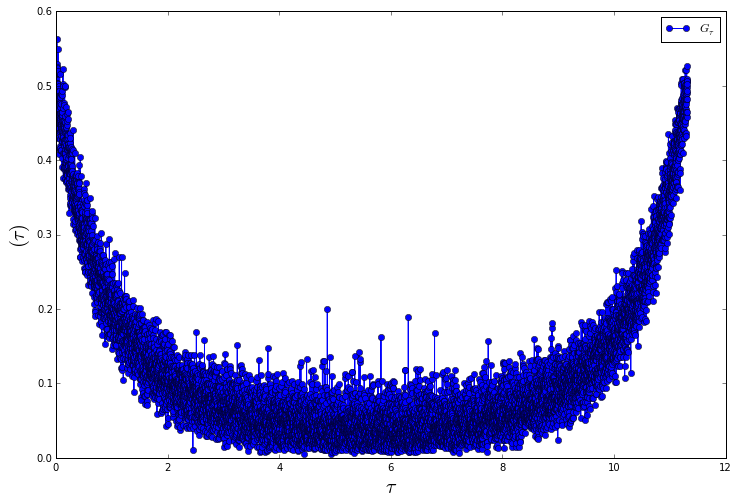

In [8]:
from pytriqs.gf.local import *
from pytriqs.archive import *
from pytriqs.plot.mpl_interface import oplot

A = HDFArchive("solution_hightemp.h5")
G_iw = GfImFreq(indices = [0], beta = 50.0)
G_iw << Fourier(A['G_tau']['up'])
#oplot(G_iw, '-o', x_window = (0,10), name = "G_up")
oplot(-1.0 * A['G_tau']['up'], '-o', x_window = (0,20), name=r"$G_\tau$")

In [7]:
beta * D / math.sqrt(2.0)

8.0

In [2]:
from pytriqs.gf.local import *
from pytriqs.gf.local import *
from pytriqs.operators import *
from pytriqs.archive import *
import pytriqs.utility.mpi as mpi

# Set up a few parameters
U = 2.5
half_bandwidth = 1.0
chemical_potential = U/2.0
beta = 100
n_loops = 5

# Construct the CTQMC solver
from pytriqs.applications.impurity_solvers.cthyb import Solver
S = Solver(beta = beta, gf_struct = { 'up':[0], 'down':[0] })

# Set the solver parameters
params = {}
params['n_cycles'] = 1000000                # Number of QMC cycles
params['length_cycle'] = 200                # Length of one cycle
params['n_warmup_cycles'] = 10000           # Warmup cycles

# Initalize the Green's function to a semi-circular density of states
g0_iw = GfImFreq(indices = [0], beta = 100)
g0_iw << SemiCircular(half_bandwidth)
for name, g0block in S.G_tau:
    g0block << InverseFourier(g0_iw)

# Now do the DMFT loop
for IterationNumber in range(n_loops):

    # Compute S.G0_iw with the self-consistency condition while imposing paramagnetism
    g = 0.5 * Fourier( S.G_tau['up'] + S.G_tau['down'] )
    for name, g0 in S.G0_iw:
        g0 << inverse( iOmega_n + chemical_potential - (half_bandwidth/2.0)**2  * g )

    # Run the solver
    S.solve(h_loc = U * n('up',0) * n('down',0), **params)

    # Some intermediate saves
    if mpi.is_master_node():
      R = HDFArchive("single_site_bethe_parallel.h5")
      R["G_tau-%s"%IterationNumber] = S.G_tau
      del R

!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------------------------------------------------!
!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------------------------------------------------!
!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------

Starting on 1 Nodes at : 2015-03-30 16:56:16.006785


HDFArchive (partial view) with the following content:
  G_tau-0 : subgroup
  G_tau-1 : subgroup
  G_tau-2 : subgroup
  G_tau-3 : subgroup
  G_tau-4 : subgroup


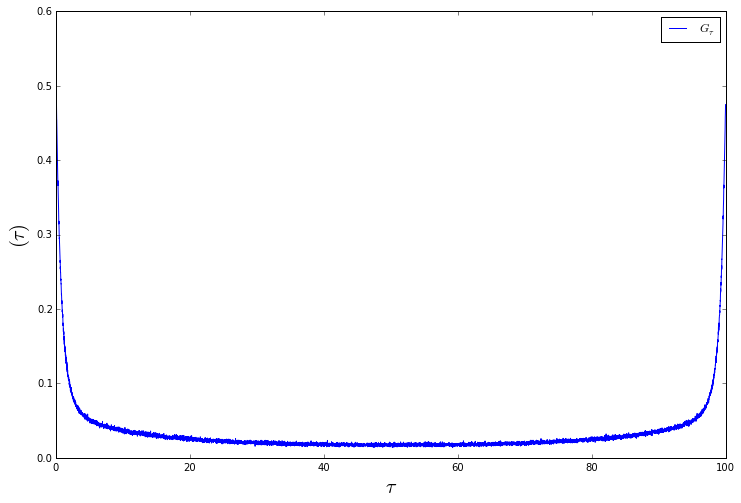

In [17]:
from pytriqs.gf.local import *
from pytriqs.archive import *
from pytriqs.plot.mpl_interface import oplot

A = HDFArchive("single_site_bethe.h5")
print A
G_tau = -1.0 * A['G_tau-4']['up']
#G_iw << Fourier(A['G_tau-4']['up'])
#oplot(G_iw, '-o', x_window = (0,10), name = "G_up")
oplot(G_tau, x_window = (0,100), name=r"$G_\tau$")

In [2]:
from pytriqs.gf.local import *
from pytriqs.gf.local import *
from pytriqs.operators import *
from pytriqs.archive import *
import pytriqs.utility.mpi as mpi
import math
from pytriqs.applications.impurity_solvers.cthyb import Solver

# Set up a few parameters
U = 2.5
half_bandwidth = 1.0
U = 3.0 * half_bandwidth / math.sqrt(2.0)
chemical_potential = U/2.0
beta = math.sqrt(2.0) * 8.0 / half_bandwidth
n_loops = 5

# Construct the CTQMC solver
S = Solver(beta=beta, gf_struct = {'up':[0], 'down':[0]})

# Set the solver parameters
params = {}
params['n_cycles'] = 1000000                # Number of QMC cycles
params['length_cycle'] = 200                # Length of one cycle
params['n_warmup_cycles'] = 10000           # Warmup cycles

# Initalize the Green's function to a semi-circular density of states
g0_iw = GfImFreq(indices = [0], beta=beta)
g0_iw << SemiCircular(half_bandwidth)
for name, g0block in S.G_tau:
    g0block << InverseFourier(g0_iw)

# Now do the DMFT loop
for IterationNumber in range(n_loops):

    # Compute S.G0_iw with the self-consistency condition while not imposing paramagnetism
    #g = 0.5 * Fourier( S.G_tau['up'] + S.G_tau['down'] )
    for spin, g0 in S.G0_iw:
        g0 << inverse(iOmega_n + chemical_potential - (half_bandwidth/2.0)**2 * Fourier(S.G_tau[spin]))

    # Run the solver
    S.solve(h_loc = U * n('up',0) * n('down',0), **params)

    # Some intermediate saves
    if mpi.is_master_node():
      R = HDFArchive("single_site_bethe_parallel.h5")
      R["G_tau-%s"%IterationNumber] = S.G_tau
      del R

!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------------------------------------------------!
!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------------------------------------------------!
!------------------------------------------------------------------------------------!
! WARNING: Using default high-frequency tail fitting parameters in the CTHYB solver. !
! You should check that the fitting range is suitable for your calculation!          !
!------------------------------------------

Starting on 1 Nodes at : 2015-03-30 17:15:16.816942


11.313708499


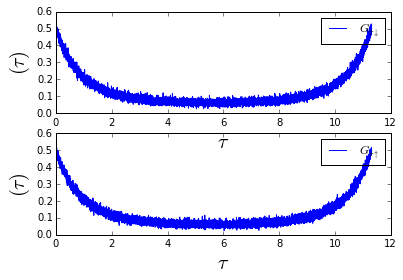

In [11]:
from pytriqs.gf.local import *
from pytriqs.archive import *
from pytriqs.plot.mpl_interface import oplot
print beta
A = HDFArchive("single_site_bethe_parallel.h5")
G_tau_up = -1.0 * A['G_tau-4']['up']
G_tau_down = -1.0 * A['G_tau-4']['down']
#G_iw << Fourier(A['G_tau-4']['up'])
#oplot(G_iw, '-o', x_window = (0,10), name = "G_up")
from pytriqs.plot.mpl_interface import subplots
f, (t,b) = subplots( 2,1)
t.oplot(G_tau_down, x_window = (0,12), name=r"$G_{\tau\downarrow}$")
b.oplot(G_tau_up, x_window = (0,12), name=r"$G_{\tau\uparrow}$")